## Kosten van uniforme doorsnede-eisen
Een belangrijke vraag bij het ontwerp is de verdeling van doorsnede-eisen over de mechanismen.
In dit notebook kijken we naar de kosten van verschillende ontwerpeisen, waarbij we de ontwerpeisen uniform houden per dijkvak. 
Dat geeft inzicht in:
* Wat optimale (uniforme/top-down) eisen zijn voor het traject
* Wat de eventuele meerwaarde is van het varieren van eisen over mechanismen en vakken (conform veiligheidsrendement)

We kunnen naar verschillende trajecten kijken. Eerst vergelijken we veiligheidsrendement met uniforme (top-down) ontwerpeisen. Daarna kijken we naar de verdeling van faalkans over de lengte van het traject (hoeveel van de trajectlengte draagt bij?).

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
import itertools
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.common_functions.database_analytics import *
from postprocessing.common_functions.database_access_functions import * 

from postprocessing.common_functions.vrtool_optimization_object import VRTOOLOptimizationObject
from postprocessing.common_functions.vrtool_measures_object import VRTOOLMeasuresObject
from postprocessing.common_functions.uniform_requirements_analysis import UniformRequirementsAnalysis

from postprocessing.common_functions.generate_output import *
import matplotlib.pyplot as plt

from common_functions.Deltares_colors import Deltares_colors 
sns.set(style="whitegrid")
colors =  Deltares_colors().sns_palette("DeltaresFull")

In [2]:
colors

[(0.03137254901960784, 0.047058823529411764, 0.5019607843137255),
 (0.050980392156862744, 0.2196078431372549, 0.8784313725490196),
 (0.054901960784313725, 0.7333333333333333, 0.9411764705882353),
 (0.0, 0.7019607843137254, 0.5372549019607843),
 (0.0, 0.8, 0.5882352941176471),
 (0.0, 0.9019607843137255, 0.6313725490196078),
 (1.0, 0.5882352941176471, 0.050980392156862744),
 (1.0, 0.8470588235294118, 0.0784313725490196),
 (0.9019607843137255, 0.9019607843137255, 0.9019607843137255),
 (0.0, 0.0, 0.0)]

In [3]:
# root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten (N=4)")
# root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten")
root_dir = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\N=4 database_rerun")
# root_dir = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases")
db_path = root_dir.joinpath("38-1","38-1_basis.db")
# db_path = root_dir.joinpath("10-1","database_10-1_LBO1.sqlite")
# db_path = root_dir.joinpath("10-1","database_10-1_trajectaanpak.sqlite")
# db_path = root_dir.joinpath("10-2","database_10-2.sqlite")
# db_path = root_dir.joinpath("10-3","database_10-3.sqlite")
# db_path = root_dir.joinpath("24-3","24-3_database.db")
# db_path = root_dir.joinpath("16-1","16-1_results.db")

# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten\10-1\database_10-1_LBO1.sqlite")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\10-2\database_10-2.sqlite")
# db_path = Path(r"n:\Projects\11209000\11209353\B. Measurements and calculations\008 - Resultaten Proefvlucht\Alle_Databases\met lengte-effecten\24-3\24-3_database.db")
has_revetment = False
design_year = 50
LE = 4 # ['no', 4, 'full'] 
# LE = 'full'
# LE = 'no'

_runs_overview = get_overview_of_runs(db_path)
_runs_overview

[{'id': 1,
  'name': 'Basisberekening Veiligheidsrendement',
  'discount_rate': 0.03,
  'optimization_type': 1,
  'optimization_type_name': 'VEILIGHEIDSRENDEMENT'},
 {'id': 2,
  'name': 'Basisberekening Doorsnede-eisen',
  'discount_rate': 0.03,
  'optimization_type': 2,
  'optimization_type_name': 'DOORSNEDE-EISEN'}]

In [4]:
vrm_run = VRTOOLOptimizationObject(db_path, 1)
vrm_run.get_all_optimization_results()
vrm_run.postprocess_optimization_steps()

dsn_run = VRTOOLOptimizationObject(db_path, 2)
dsn_run.get_all_optimization_results()


Now we are going to read the measures for each section, and for a grid of probabilities determine the costs associated with meeting a set of requirements for overflow, stability & piping. This grid runs from the standard to 100000 more stringent for each.

In [5]:
measure_set = VRTOOLMeasuresObject(db_path, LE_scenario=LE, design_year=50)

In [6]:
uniform_requirements = UniformRequirementsAnalysis(measure_set, total_space=0.52)

#add a large grid
N_omega = [2., 3., 4., 6., 8., 16., 32.] #automatically applied for all mechanisms
N_LE = [5., 10., 20., 40., 50.] #only applied for piping and stability inner

uniform_requirements.make_Nbased_grid(N_omega, N_LE)
uniform_requirements.analyze_Nbased_grid()


In [7]:
#add specific grid
N_omega_dict = {MechanismEnum.OVERFLOW: [1./.24, 1./.1, 1./.24],
                MechanismEnum.PIPING: [1./.24, 1./.24, 1./.04],
                MechanismEnum.STABILITY_INNER: [1./.04, 1./.18, 1./.24]}

LE_grid = {MechanismEnum.PIPING: [.9, .5], 
           MechanismEnum.STABILITY_INNER: [.033, .033]}

uniform_requirements.make_dict_based_grid(N_omega_dict, LE_grid)
uniform_requirements.analyze_specific_grid()



In [8]:
uniform_requirements.cost_grid_specific


[343368152.34281844,
 343368152.34281844,
 349729259.24384415,
 349729259.24384415,
 416241752.5666631,
 416241752.5666631]

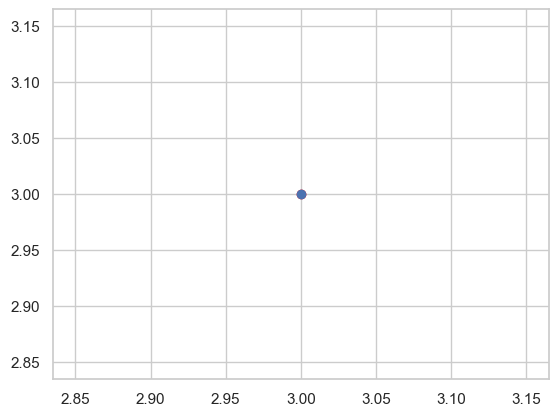

In [9]:
plt.plot(3,3,marker = 'o', zorder=1000)
plt.plot(3,3,marker = 'o', zorder=10,color='red')

C:\Repositories\VRSuiteUtils\postprocessing\common_functions\uniform_requirements_analysis.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);


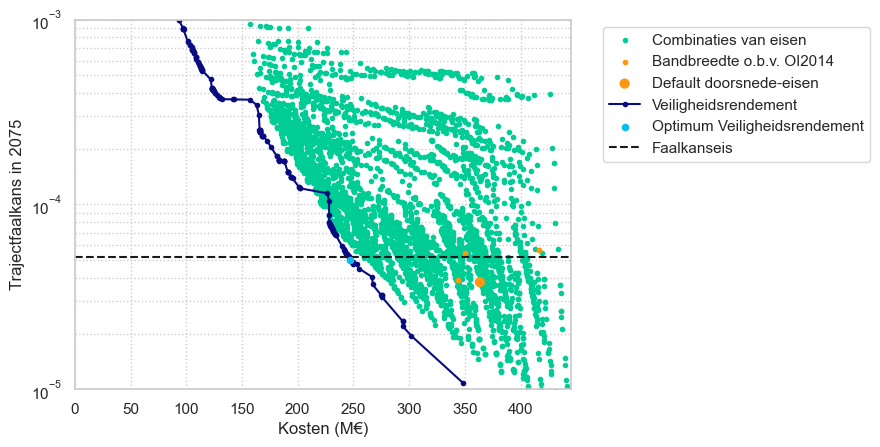

In [10]:
#make & save the figure
save_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen')
uniform_requirements.plot_results(vrm_run, save_dir, dsn_run, LE=LE)


Generate a standardized factsheet for the uniform requirements

In [8]:

save_path = save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_N={LE}_factsheet.csv')
uniform_requirements.generate_factsheet(vrm_run)

uniform_requirements.factsheet.to_csv(save_path, index=False)

Determine the requirements that follow from a VRM computation

In [ ]:
vrm_run.set_step_data(step = 'Standard in year', year = 2075, pf_req = uniform_requirements.p_max_space)
vrm_run.requirements_from_vrm()

vrm_run.requirements.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_N={LE}_requirements_from_vrm.csv'), float_format='%.3f')

Determine the measures that follow from a vrm computation

In [ ]:
vrm_run.measures_from_vrm()

vrm_run.measures_df.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_N={LE}_measures_from_vrm.csv'), float_format='%.3f')


## Analyse van kosten bij verschillende eisen

Het is ook mogelijk om voor 1 set specifieke eisen direct kosten en maatregelen te bepalen.

In [ ]:
uniform_requirements.calculate_cost(pf_to_beta(1./10), pf_to_beta(1./10), pf_to_beta(uniform_requirements.p_max/317), uniform_requirements.measures)

(60992888.30508,
 0.02108267987876511,
        measure_result  section_id  Overflow    Piping  StabilityInner  \
 0                   1           1  3.490467  2.784439        5.834476   
 292               222           2  3.960133  2.740783        4.850165   
 565               442           3  3.947767  2.745494        4.754515   
 838               665           4  3.964633  3.022063        4.931327   
 1047              881           5  3.524667  2.671723        5.552391   
 1511             1320           6  3.198967  4.929915        5.953813   
 1548             1321           7  3.561867  5.124102        7.991574   
 1840             1547           8  3.677033  4.648707        5.213404   
 2167             1980           9  3.312667  5.256516        5.511821   
 2195             1986          10  3.551667  4.477613        5.058106   
 2386             2202          11  3.573700  4.347861        5.047089   
 2659             2425          12  3.863933  3.093967        4.815829   

Betas van maatregelen horend bij optimale uniforme eisen

In [ ]:
uniform_requirements.measures_Nbased_optimal.head()
uniform_requirements.measures_Nbased_optimal.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_optimal_uniform_N={LE}.csv'))

Maatregelen horend bij uniforme optimale eisen

In [ ]:
N_based_optimal_measure_parameters = uniform_requirements.get_measure_parameters(uniform_requirements.measures_Nbased_optimal,db_path=db_path)
N_based_optimal_measure_parameters.to_csv(save_dir.joinpath(f'{DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name}_optimal_uniform_N={LE}_parameters.csv'))


Maatregelen horend bij andere eisen

In [ ]:
specific_betas = [item[0] for item in uniform_requirements.specific_target_beta_grid.values()]
#ensure that order is right!
cost, pf, measures = uniform_requirements.calculate_cost(*specific_betas, uniform_requirements.measures)

uniform_requirements.get_measure_parameters(measures,db_path=db_path).head()        

,section_id,name,cost,dcrest,dberm,l_stab_screen
0,1,Zelfkerende constructie,1.227421e+07,NaN,NaN,NaN
1,2,Zelfkerende constructie,7.726940e+06,NaN,NaN,NaN
2,3,Zelfkerende constructie,2.704429e+07,NaN,NaN,NaN
3,4,Zelfkerende constructie,1.210326e+07,NaN,NaN,NaN
4,5,Verticaal Zanddicht Geotextiel + Grondversterk...,2.097529e+07,0.5,30.0,NaN
